# Exploratory Analysis

In this notebook we explore data looking for some valuable insights that will help in model development.

In [1]:
import pandas as pd
import numpy as np
from plotnine import *

## Ratings Distribution

Let's take a look at the ratings dataset.

In [2]:
ratings = pd.read_csv('data/movie_ratings.csv')
ratings.head()

,user,id,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In [3]:
'Num. Users: {}'.format(ratings['user'].nunique())

'Num. Users: 273643'

In [4]:
'Num. Movies: {}'.format(ratings['id'].nunique())

'Num. Movies: 15967'

Here we check the vote proportion in each rating level:

In [5]:
rating_prop = ratings.groupby('rating').agg(
    count=pd.NamedAgg(column='rating', aggfunc='count')
).reset_index(drop=False)
rating_prop['percent'] = 100 * rating_prop['count'] / rating_prop['count'].sum()
display(rating_prop)

,rating,count,percent
0,0.5,429197,1.559762
1,1.0,876669,3.185938
2,1.5,433139,1.574088
3,2.0,1832493,6.659536
4,2.5,1348596,4.900986
5,3.0,5466620,19.866461
6,3.5,3361124,12.214794
7,4.0,7356391,26.734152
8,4.5,2359304,8.574040
9,5.0,4053296,14.730244


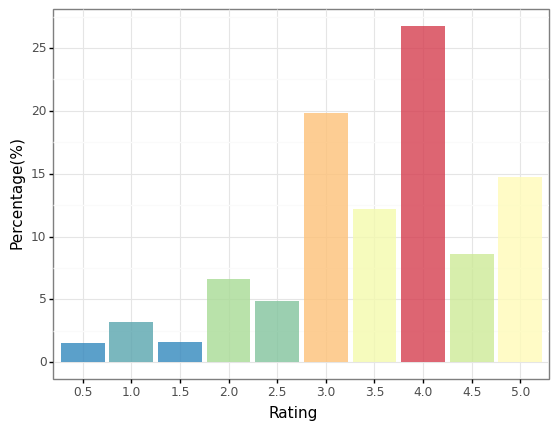

In [6]:
g = ggplot(rating_prop, aes(x='factor(rating)', y='percent', fill='percent')) +\
    geom_col(size=1, alpha=0.8) +\
    scale_fill_distiller(guide=None, type='div', palette='Spectral') +\
    scale_y_continuous(breaks=np.arange(0, 100, 5)) +\
    labs(x='Rating', y='Percentage(%)') +\
    theme_bw()
g = g.draw(return_ggplot=True)

Just a small part of the votes fall below 3.0, the same for the movie average rating:

<AxesSubplot:>

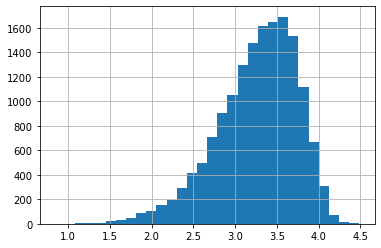

In [7]:
ratings.groupby('id').agg(rating=('rating', 'mean')).rating.hist(bins=30)

## Ratings as Likes and Dislikes

Now, let's covert rantings into likes (>= 3.5) and dislikes (< 3.5). 

In [8]:
ratings['like'] = np.where(ratings['rating'] >= 3.5, 1.0, 0.0)
ratings.head()

,user,id,rating,like
0,1,307,3.5,1.0
1,1,481,3.5,1.0
2,1,1091,1.5,0.0
3,1,1257,4.5,1.0
4,1,1449,4.5,1.0


In [9]:
movie_likes = ratings.groupby(['id','like']).agg(
    count=pd.NamedAgg(column='like', aggfunc='count')
).reset_index(drop=False).set_index('id')
movie_likes.head()

,like,count
id,,
1,0.0,17471
1,1.0,50939
2,0.0,14793
2,1.0,12345
3,0.0,9718


<AxesSubplot:>

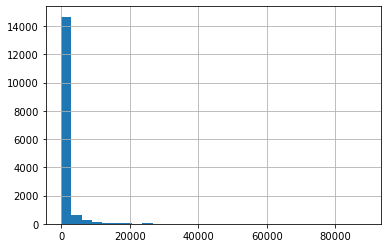

In [10]:
avg_rating = ratings.groupby('id').agg(
    num_likes=pd.NamedAgg(column='like', aggfunc='sum'),
    rating=pd.NamedAgg(column='rating', aggfunc='mean')
)

avg_rating.num_likes.hist(bins=30)

<AxesSubplot:xlabel='num_likes', ylabel='rating'>

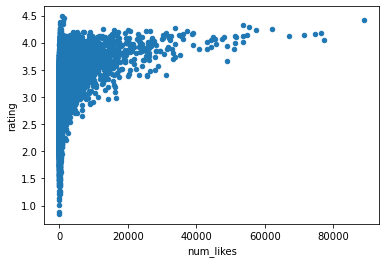

In [11]:
avg_rating.plot.scatter(x='num_likes', y='rating')

Here we obseerve a rating bias for movies with a massive number of likes. They are likely to have average rating above 3.5.

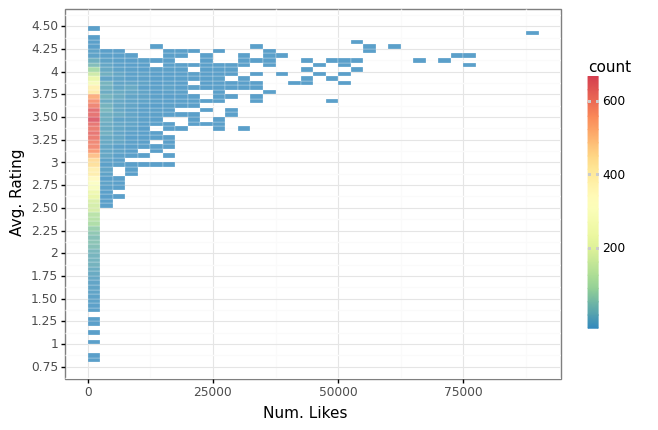

In [12]:
g = ggplot(avg_rating, aes(x='num_likes', y='rating')) +\
    geom_bin2d(binwidth=[2500, 0.05], alpha=0.8, size=0.1, color='#ffffff') +\
    scale_fill_distiller(type='div', palette='Spectral') +\
    scale_y_continuous(breaks=np.arange(0, 5, 0.25)) +\
    guides(fill = guide_colourbar(barwidth=5, barheight=25)) +\
    labs(x='Num. Likes', y='Avg. Rating') +\
    theme_bw()
g = g.draw(return_ggplot=True)

## Most Liked and Most Hated Movies

It's just a sanity test. For me the results make sense, but the final conclusions are personal.

In [13]:
movies = pd.read_csv('data/movie_info.csv')
movies.set_index('id', inplace=True) 
movies = movies.join(movie_likes)

In [14]:
movies.sort_values(['count'], ascending=False, inplace=True)
movies.loc[movies['like']==1].head(10)

,original_title,title,overview,tagline,like,count
id,,,,,,
318,The Shawshank Redemption,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,Fear can hold you prisoner. Hope can set you f...,1.0,88846.0
356,Forrest Gump,Forrest Gump,A man with a low IQ has accomplished great thi...,"The world will never be the same, once you've ...",1.0,77143.0
296,Pulp Fiction,Pulp Fiction,"A burger-loving hit man, his philosophical par...",Just because you are a character doesn't mean ...,1.0,76334.0
593,The Silence of the Lambs,The Silence of the Lambs,"FBI trainee, Clarice Starling ventures into a ...",To enter the mind of a killer she must challen...,1.0,74607.0
2571,The Matrix,The Matrix,"Set in the 22nd century, The Matrix tells the ...",Welcome to the Real World.,1.0,71266.0
260,Star Wars,Star Wars,Princess Leia is captured and held hostage by ...,"A long time ago in a galaxy far, far away...",1.0,66945.0
527,Schindler's List,Schindler's List,The true story of how businessman Oskar Schind...,"Whoever saves one life, saves the world entire.",1.0,62012.0
2959,Fight Club,Fight Club,A ticking-time-bomb insomniac and a slippery s...,Mischief. Mayhem. Soap.,1.0,57479.0
50,The Usual Suspects,The Usual Suspects,"Held in an L.A. interrogation room, Verbal Kin...",Five Criminals. One Line Up. No Coincidence.,1.0,55297.0


In [15]:
movies.loc[movies['like']==0].head(10)

,original_title,title,overview,tagline,like,count
id,,,,,,
344,Ace Ventura: Pet Detective,Ace Ventura: Pet Detective,He's Ace Ventura: Pet Detective. Jim Carrey is...,"He's the best there is! (Actually, he's the on...",0.0,29083.0
592,Batman,Batman,The Dark Knight of Gotham City begins his war ...,Have you ever danced with the devil in the pal...,0.0,28837.0
153,Batman Forever,Batman Forever,The Dark Knight of Gotham City confronts a das...,"Courage now, truth always...",0.0,28704.0
780,Independence Day,Independence Day,"On July 2, a giant alien mothership enters orb...",Earth. Take a good look. It might be your last.,0.0,27731.0
480,Jurassic Park,Jurassic Park,A wealthy entrepreneur secretly creates a them...,An adventure 65 million years in the making.,0.0,27542.0
231,Dumb and Dumber,Dumb and Dumber,Lloyd and Harry are two men whose stupidity is...,"What the one doesn't have, the other is missing.",0.0,23697.0
380,True Lies,True Lies,Harry Tasker is a secret agent for the United ...,"When he said I do, he never said what he did.",0.0,23032.0
736,Twister,Twister,TV weatherman Bill Harding is trying to get hi...,The Dark Side of Nature.,0.0,22670.0
367,The Mask,The Mask,When timid bank clerk Stanley Ipkiss discovers...,From zero to hero.,0.0,22388.0


## Genre Distribution

Now let's check movie genres. Which one is the most popular?

In [16]:
genres = pd.read_csv('data/movie_genre.csv')
genres['genre_name'].value_counts()

Drama              9053
Comedy             6240
Thriller           4756
Action             3872
Romance            3415
Horror             3160
Crime              2606
Adventure          2116
Science Fiction    1971
Family             1466
Mystery            1426
Fantasy            1259
Documentary        1156
Music               839
Animation           717
Western             683
War                 655
History             608
Foreign             321
TV Movie            207
Name: genre_name, dtype: int64

In [17]:
genre_prop = genres.groupby('genre_name').agg(
    count=pd.NamedAgg(column='genre_name', aggfunc='count')
).reset_index(drop=False)
genre_prop['percent'] = 100 * genre_prop['count'] / genre_prop['count'].sum()
display(genre_prop)

,genre_name,count,percent
0,Action,3872,8.322228
1,Adventure,2116,4.547995
2,Animation,717,1.541074
3,Comedy,6240,13.411856
4,Crime,2606,5.601169
5,Documentary,1156,2.484632
6,Drama,9053,19.457937
7,Family,1466,3.150926
8,Fantasy,1259,2.706014
9,Foreign,321,0.689937


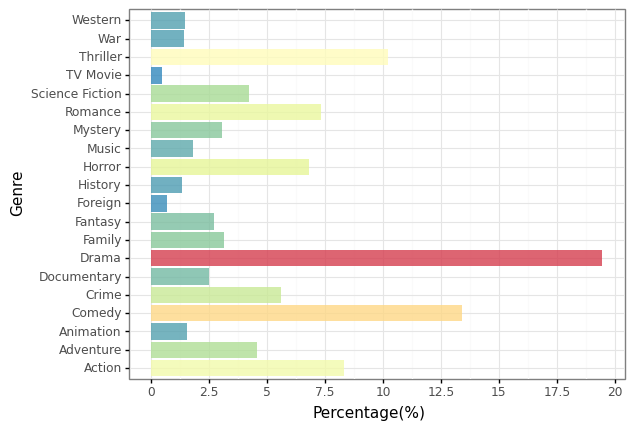

In [18]:
g = ggplot(genre_prop, aes(x='factor(genre_name)', y='percent', fill='percent')) +\
    geom_col(size=1, alpha=0.8) +\
    scale_fill_distiller(guide=None, type='div', palette='Spectral') +\
    scale_y_continuous(breaks=np.arange(0, 100, 2.5)) +\
    labs(x='Genre', y='Percentage(%)') +\
    coord_flip() +\
    theme_bw()
g = g.draw(return_ggplot=True)

## Most Liked Western and Horror Movies

In [19]:
western_movies = genres.loc[genres['genre_name']=='Western', 'id']
movies.loc[(movies['like']==1) & movies.index.isin(western_movies)].head(10)

,original_title,title,overview,tagline,like,count
id,,,,,,
590,Dances with Wolves,Dances with Wolves,"Wounded Civil War soldier, John Dunbar tries t...",Inside everyone is a frontier waiting to be di...,1.0,33822.0
99114,Django Unchained,Django Unchained,"With the help of a German bounty hunter, a fre...","Life, liberty and the pursuit of vengeance.",1.0,17188.0
1201,"Il buono, il brutto, il cattivo","The Good, the Bad and the Ugly",While the Civil War rages between the Union an...,For three men the Civil War wasn't hell. It wa...,1.0,16676.0
1304,Butch Cassidy and the Sundance Kid,Butch Cassidy and the Sundance Kid,"In late 1890s Wyoming, Butch Cassidy is the af...","Not that it matters, but most of it is true.",1.0,14481.0
1266,Unforgiven,Unforgiven,"William Munny is a retired, once-ruthless kill...",Some legends will never be forgotten. Some wro...,1.0,13387.0
553,Tombstone,Tombstone,"Legendary marshal Wyatt Earp, now a weary gunf...",Justice is coming.,1.0,10269.0
3671,Blazing Saddles,Blazing Saddles,A town – where everyone seems to be named John...,Never give a saga an even break!,1.0,9751.0
368,Maverick,Maverick,Maverick is a gambler who would rather con som...,"In their hands, a deck of cards was the only t...",1.0,9694.0
2951,Per un pugno di dollari,A Fistful of Dollars,The Man With No Name enters the Mexican villag...,"In his own way he is perhaps, the most dangero...",1.0,6666.0


In [20]:
horror_movies = genres.loc[genres['genre_name']=='Horror', 'id']
movies.loc[(movies['like']==1) & movies.index.isin(horror_movies)].head(10)

,original_title,title,overview,tagline,like,count
id,,,,,,
1214,Alien,Alien,"During its return to the earth, commercial spa...",In space no one can hear you scream.,1.0,32325.0
1200,Aliens,Aliens,When Ripley's lifepod is found by a salvage cr...,This Time It's War,1.0,27645.0
1258,The Shining,The Shining,Jack Torrance accepts a caretaker job at the O...,A masterpiece of modern horror.,1.0,26290.0
1219,Psycho,Psycho,When larcenous real estate clerk Marion Crane ...,The master of suspense moves his cameras into ...,1.0,19887.0
1387,Jaws,Jaws,An insatiable great white shark terrorizes the...,Don't go in the water.,1.0,18761.0
253,Interview with the Vampire,Interview with the Vampire,"A vampire relates his epic life story of love,...",Drink from me and live forever,1.0,17297.0
8874,Shaun of the Dead,Shaun of the Dead,"Shaun lives a supremely uneventful life, which...",A romantic comedy. With zombies.,1.0,16134.0
6502,28 Days Later,28 Days Later,Twenty-eight days after a killer virus was acc...,His fear began when he woke up alone. His terr...,1.0,13346.0
1997,The Exorcist,The Exorcist,12-year-old Regan MacNeil begins to adapt an e...,Something almost beyond comprehension is happe...,1.0,11961.0


## Most Liked and Most Hated Directors

Sum up movie likes (+1) with dislikes (-1) aggregated by director:

In [21]:
directors = pd.read_csv('data/movie_producer.csv')

'Num. Directors: {}'.format(directors.loc[directors['job']=='Director', 'person_id'].nunique())

'Num. Directors: 2503'

In [22]:
directors = directors.loc[directors['job']=='Director'].set_index('id').join(movie_likes)
directors = directors.groupby(['person_name','like']).agg(
    count=pd.NamedAgg(column='count', aggfunc='sum')
).reset_index(drop=False)
directors['like'] = np.where(directors['like']==1, 1, -1)
directors['count'] = directors['count'] * directors['like']
directors = directors.groupby(['person_name']).agg(
    count=pd.NamedAgg(column='count', aggfunc='sum')
).reset_index(drop=False)

directors.sort_values('count', ascending=False).head(10)

,person_name,count
1730,Steven Spielberg,269758.0
326,Christopher Nolan,169616.0
1455,Quentin Tarantino,164889.0
1414,Peter Jackson,134236.0
1192,Martin Scorsese,125040.0
407,David Fincher,123644.0
1560,Robert Zemeckis,123116.0
896,Joel Coen,114318.0
1513,Ridley Scott,110348.0
1694,Stanley Kubrick,108636.0


In [23]:
directors.sort_values('count').head(10)

,person_name,count
1811,Tom Shadyac,-23201.0
898,Joel Schumacher,-18418.0
568,Frank Marshall,-16645.0
1481,Renny Harlin,-16169.0
227,Brian Levant,-15459.0
330,Chuck Russell,-14196.0
1712,Steve Barron,-12376.0
1683,Simon Wincer,-12282.0
1389,Paul W.S. Anderson,-12178.0
1718,Steve Oedekerk,-12083.0


## Most Liked and Most Hated Actors

Sum up movies likes (+1) with dislikes (-1) aggregated by actor:

In [24]:
actors = pd.read_csv('data/movie_actor.csv')

'Num. Actors: {}'.format(actors['actor_id'].nunique())

'Num. Actors: 10465'

In [25]:
actors = actors.set_index('id').join(movie_likes)
actors = actors.groupby(['actor_name','like']).agg(
    count=pd.NamedAgg(column='count', aggfunc='sum')
).reset_index(drop=False)
actors['like'] = np.where(actors['like']==1, 1, -1)
actors['count'] = actors['count'] * actors['like']
actors = actors.groupby(['actor_name']).agg(
    count=pd.NamedAgg(column='count', aggfunc='sum')
).reset_index(drop=False)

actors.sort_values('count', ascending=False).head(20)

,actor_name,count
7811,Philip Ettington,395555.0
3715,Harrison Ford,313386.0
9587,Tom Hanks,269594.0
8748,Samuel L. Jackson,249131.0
1123,Brad Pitt,245564.0
5029,John Ratzenberger,237802.0
7090,Morgan Freeman,228893.0
6608,Matt Damon,226620.0
3963,Hugo Weaving,217895.0
4265,James Earl Jones,202880.0


In [26]:
actors.sort_values('count').head(20)

,actor_name,count
8280,Rob Schneider,-37207.0
7511,Pat Hingle,-29946.0
9292,Sylvester Stallone,-26230.0
4697,Jim Carrey,-25171.0
1204,Bridgette Wilson,-24518.0
1879,Courteney Cox,-24107.0
4500,Jean-Claude Van Damme,-23798.0
7796,Phil Hartman,-23769.0
1628,Chris O'Donnell,-22480.0
9230,Stuart Pankin,-21718.0
